# Analysing polish 2019 sejm election results - impact of position on committee list

## Part 0: What and why?

Whole idea started from some stupid Twitter discussion. Yeah, really.

The initial goal was to just prove that no 1 on a committee list is **VERY** significant. But then, I decided that there is maybe a bit more useless insight to get from that data. So, Im trying to find everything that affects how much votes a candidate got in 2019 polish sejm elections (that is derived from list itself, not personalities of politicians). Also, how lists of diffrent parties vary.
Most of the testing will be done using data for Konf, as I expect the most extreme results from them

## Part 1: Get the data

Why data scraping when there are databases of that availible? Quite simple - I just wanted to practise data scraping.

#### Import the libraries

In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

#### Define function for web scraping

In [9]:
def get_data(partia, nr_okregu):
    driver.switch_to.new_window('tab')
    url = "https://sejmsenat2019.pkw.gov.pl/sejmsenat2019/pl/wyniki/komitet/" + partia + "/sejm/okr/" + nr_okregu
    driver.get(url)
    # wait for page to load
    driver.implicitly_wait(2)
    #get the container of our data
    tabela = driver.find_element(By.ID, "DataTables_Table_1_wrapper")
    j = -1
    dane = []
    osoba_even = tabela.find_elements(By.CLASS_NAME, 'even')
    for i in range(1, (len(osoba_even) * 2) + 1):
        # there is some optimization to do
        if i % 2 == 1:
            odd_or_even = "odd"
            j += 1
        else:
            odd_or_even = "even"
        osoba = tabela.find_elements(By.CLASS_NAME, odd_or_even)[j]
        wynik = osoba.find_elements(By.TAG_NAME, "td")[2]
        result = ''
        # should've use .split fuction (!)
        for char in wynik.text:
            if char != " ":
                result += char
        # Fun fact - there is one instance of a candidate death days before the election that made that function dead, so that check is just for one guy. 
        if result != '':
            wynik = int(result)
        else:
            wynik = 0
        dane.append([i, wynik])
    # driver.close() <- for some reason function crashes with that, dont have the will to investigate so enjoy over 200 chrome tabs open :D
    with open('election_data2.txt', 'a') as file:
        i = 0
        for i in dane:
            file.write(f'{i[0]} {i[1]} {komitet_id[partia]} {nr_okregu}\n')

#### Create dictionary and list for our data scrap

In [6]:
komitet_id = {
    "26073": "Konf",
    "26079": "PiS",
    "26075": "KO",
    "26091": "PSL",
    "26063": "SLD"
}
komitet_list = {"26073", "26075", "26091", "26063", '26079'}

#### Get the data

This surely is not the efficient way, but it has do be done only once - to save the data so it's <u>good enough</u>.

In [7]:
options = webdriver.ChromeOptions()
options.add_experimental_option("detach", True)
PATH = "C:\Program Files (x86)\chromedriver.exe"
driver = webdriver.Chrome(options=options, service=Service(ChromeDriverManager().install()))
driver.get('about:blank')

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.79M/6.79M [00:03<00:00, 2.25MB/s]


Be wary - this opens 205 chrome tabs and takes a while.

In [ ]:
# reset the  election_data.txt if nessesery
# open('election_data.txt', 'w').close()

for committee in komitet_list:
    for const in range(1, 42):
        get_data(str(committee), str(const))
driver.quit()

## Part 2: Transform the data

#### Import pandas

In [2]:
import pandas as pd

#### save data in pandas dataFrame format

In [3]:
temp_list = []
with open('election_data.txt', 'r') as file:
            for line in file:
                line = line.split(' ')
                line[3] = line[3][:-1]
                temp_list.append(line)
df_raw = pd.DataFrame(temp_list, columns=['nr_on_list', 'votes', 'committee', 'constituency'])
df_raw = df_raw.astype({'nr_on_list' : 'uint16', 'votes' : 'uint32', 'committee' : 'unicode_', 'constituency' : 'uint16'})
df_raw.head()
                
                

,nr_on_list,votes,committee,constituency
0,1,6358,Konf,1
1,2,2313,Konf,1
2,3,2413,Konf,1
3,4,677,Konf,1
4,5,850,Konf,1


#### sum all votes in constituency per committee

In [4]:
df_committee = df_raw[['constituency', 'committee', 'votes']].groupby(['constituency', 'committee']).sum()
df_committee.head()

votes
constituency committee        
1            KO         108191
             Konf        25319
             PSL         31006
             PiS        183364
             SLD         71061

#### Add all votes column to each candidate

That is, all votes for a committee in that constituency, we want to get a vote share from that later

In [5]:
df_candidate = df_raw
df_candidate['all_votes'] = 0
df_candidate = df_candidate.astype({'all_votes' : 'uint32'})
def pass_vote_sum(row):
    result = df_committee['votes'].loc[row['constituency'], row['committee']]
    return result
df_candidate['all_votes'] = df_candidate.apply(lambda row: pass_vote_sum(row), axis=1)
df_candidate.head(4020) # Had some problems with data type so this checks the largest number

,nr_on_list,votes,committee,constituency,all_votes
0,1,6358,Konf,1,25319
1,2,2313,Konf,1,25319
2,3,2413,Konf,1,25319
3,4,677,Konf,1,25319
4,5,850,Konf,1,25319
...,...,...,...,...,...
4015,12,4443,KO,19,581077
4016,13,6434,KO,19,581077
4017,14,1520,KO,19,581077
4018,15,4577,KO,19,581077


#### Add a vote share of a list column for each candidate

In [6]:
df_candidate['vote_share'] = 0
df_candidate = df_candidate.astype({'vote_share' : 'uint32'})
df_candidate['vote_share'] = (df_candidate['votes']/df_candidate['all_votes'])*100
df_candidate = df_candidate.astype({'all_votes' : 'uint32', 'vote_share' : 'float32'})
df_candidate.head(4020) # as in previous, checking if the largest number didn't overflow

,nr_on_list,votes,committee,constituency,all_votes,vote_share
0,1,6358,Konf,1,25319,25.111576
1,2,2313,Konf,1,25319,9.135432
2,3,2413,Konf,1,25319,9.530393
3,4,677,Konf,1,25319,2.673881
4,5,850,Konf,1,25319,3.357163
...,...,...,...,...,...,...
4015,12,4443,KO,19,581077,0.764615
4016,13,6434,KO,19,581077,1.107254
4017,14,1520,KO,19,581077,0.261583
4018,15,4577,KO,19,581077,0.787675


#### Average vote share for each number for each committee

In [7]:
df_konf = df_candidate[['nr_on_list', 'vote_share']].loc[df_candidate['committee'] == 'Konf']
df_konf = df_konf.groupby(['nr_on_list']).mean().reset_index()

df_ko = df_candidate[['nr_on_list', 'vote_share']].loc[df_candidate['committee'] == 'KO']
df_ko = df_ko.groupby(['nr_on_list']).mean().reset_index()

df_pis = df_candidate[['nr_on_list', 'vote_share']].loc[df_candidate['committee'] == 'PiS']
df_pis = df_pis.groupby(['nr_on_list']).mean().reset_index()

df_sld = df_candidate[['nr_on_list', 'vote_share']].loc[df_candidate['committee'] == 'SLD']
df_sld = df_sld.groupby(['nr_on_list']).mean().reset_index()

df_psl = df_candidate[['nr_on_list', 'vote_share']].loc[df_candidate['committee'] == 'PSL']
df_psl = df_psl.groupby(['nr_on_list']).mean().reset_index()
df_pis.head()

,nr_on_list,vote_share
0,1,32.646935
1,2,14.054613
2,3,9.178782
3,4,7.050923
4,5,5.234852


#### Combine dataframes

In [8]:
# could've used a loop
df_mean = pd.merge(df_konf, df_ko, on='nr_on_list', how='outer')
df_mean = pd.merge(df_mean, df_pis, on='nr_on_list', how='outer')
df_mean = pd.merge(df_mean, df_sld, on='nr_on_list', how='outer')
df_mean = pd.merge(df_mean, df_psl, on='nr_on_list', how='outer')
df_average_all = df_candidate[['nr_on_list', 'vote_share']].groupby(['nr_on_list']).mean()
df_mean = pd.merge(df_mean, df_average_all, on='nr_on_list', how='outer')
df_mean.columns = ['nr_on_list', 'Konf', 'KO', 'PiS', 'SLD', 'PSL', 'All']
df_mean.head()

C:\Users\sefer\AppData\Local\Temp\ipykernel_10680\3392733109.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vote_share_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_mean = pd.merge(df_mean, df_sld, on='nr_on_list', how='outer')
C:\Users\sefer\AppData\Local\Temp\ipykernel_10680\3392733109.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vote_share_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_mean = pd.merge(df_mean, df_average_all, on='nr_on_list', how='outer')


,nr_on_list,Konf,KO,PiS,SLD,PSL,All
0,1,50.130733,36.079926,32.646935,42.508545,35.478767,39.368980
1,2,8.272799,16.822878,14.054613,16.504513,10.634875,13.257936
2,3,4.869152,10.964109,9.178782,7.431591,7.626335,8.013994
3,4,4.359488,8.006041,7.050923,5.331512,5.382879,6.026169
4,5,3.351733,5.514209,5.234852,3.773445,4.762718,4.527392


# Part 3: Analyse

## Make visualizations, find someething interesting

#### Lets look at people with most vote share

In [9]:
df_candidate.sort_values(by='vote_share', ascending=False).head(15)

,nr_on_list,votes,committee,constituency,all_votes,vote_share
3012,1,33784,PSL,15,46333,72.915634
1562,1,133687,PiS,31,184030,72.644135
266,1,36428,Konf,13,50816,71.686081
4004,1,416030,KO,19,581077,71.596367
2088,1,15204,SLD,14,22087,68.836876
1274,1,248935,PiS,19,379880,65.529907
710,1,22158,Konf,33,33895,65.372475
668,1,22191,Konf,31,34416,64.478729
454,1,14526,Konf,21,22574,64.348366
494,1,31148,Konf,23,48600,64.090538


* Number 1 is Leader of a party, not that suprising.
* Number 2 is prime minister in office, you might've expected that
* Number 3 is just a normal member, interesting that this happend. He didn't get the mandate
* Number 4 is former equivalent of speaker of the house, but she had quite popular co-candidates on her list.
* Number 5 is again, just a normal party member. As this is my constituency I can say that he was the only visible person from that committee during election time.    
Not-so-fun fact: he died recently being only 33 years old.
* After that, we can see **a lot** of Konf people. Let's investigate that later

#### Lets do the same, but reverse

In [10]:
df_candidate.sort_values(by='vote_share', ascending=True).head(10)

,nr_on_list,votes,committee,constituency,all_votes,vote_share
1317,4,0,PiS,20,241523,0.000000
1310,37,159,PiS,19,379880,0.041855
1312,39,178,PiS,19,379880,0.046857
1311,38,187,PiS,19,379880,0.049226
2218,33,180,SLD,19,251434,0.071589
4031,28,447,KO,19,581077,0.076926
420,31,85,Konf,19,103843,0.081854
4134,21,70,KO,23,84703,0.082642
1299,26,326,PiS,19,379880,0.085817
2213,28,224,SLD,19,251434,0.089089


And there is the dead guy mentioned in scraping part! I don't think there is much more intel to bo drown from that

#### The same, but only for No. 1

In [11]:
df_candidate.loc[df_candidate['nr_on_list'] == 1].sort_values(by='vote_share', ascending=True).head(10)

,nr_on_list,votes,committee,constituency,all_votes,vote_share
1384,1,38912,PiS,23,367268,10.594988
4172,1,25202,KO,25,218484,11.534941
3130,1,7195,PSL,20,51484,13.975216
4144,1,17185,KO,24,109527,15.690195
1088,1,31280,PiS,10,194658,16.069208
3774,1,23870,KO,8,136955,17.429083
990,1,54915,PiS,6,313284,17.528824
1442,1,29834,PiS,25,169753,17.574947
872,1,33269,PiS,1,183364,18.143692
1212,1,35798,PiS,16,194371,18.417356


I did not expect such low results as 10%! Lets analyse some case-by-case:
1. looking at the data from that race we can see a very close race between many people. I can't tell why is that though.
2. That one is in Gdańsk. Very important place for polish communist times opposition. Very interesting list here: **Number 1 was** actually **FOURTH**. 
* First place is No 2, I dont want to undermine his own achivments, but his last name is Wałęsa. Aaaaand hi is a son of *The* Lech Wałęsa. And this is Gdańsk
* Second place is Brother of former, murdered mayor of Gdańsk. That's surely a factor but Piotr Adamowicz has quite rich list of his own accomplishments as well
* Third place went to local leader of biggest party from that committee.
* And fourth, our No 1. A recording of his meeting was leaked two years prior and ended up with a small scandal. I think that was main factor for his poor result.


I dont believe I will find anything interesting going like that so Im gonna stop here

#### Just for fun, lets see people with least votes total

In [12]:
df_candidate.sort_values(by='votes', ascending=True).head(20)

,nr_on_list,votes,committee,constituency,all_votes,vote_share
1317,4,0,PiS,20,241523,0.000000
520,27,53,Konf,23,48600,0.109053
310,19,64,Konf,14,25747,0.248573
707,16,68,Konf,32,21650,0.314088
728,19,68,Konf,33,33895,0.200620
2538,29,69,SLD,33,56131,0.122927
2346,23,69,SLD,24,47342,0.145748
4134,21,70,KO,23,84703,0.082642
159,16,71,Konf,7,23439,0.302914
2535,26,72,SLD,33,56131,0.128271


Konf seem pretty over represented here, but they are the ones that got least votes overall, most unusual is probably amout of SLD, as they've got over 12% of votes.
But getting less then a 100 votes is a bit low.

#### visualise mean for each position split on committee

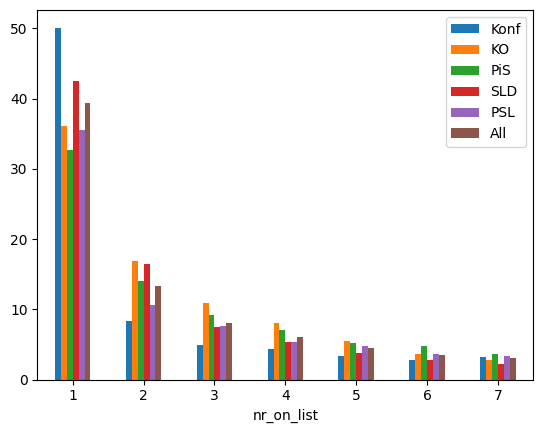

In [13]:
import matplotlib.pyplot as plt
import numpy as np
ax = df_mean.iloc[:7].plot(x="nr_on_list", y=['Konf', 'KO', 'PiS', 'SLD', 'PSL', 'All'], kind='bar', rot=0)
# colors are very confusing for anyone who knows polish politics, I will deal with it later.

The only really visible thing is that Konf relies a lot on nr 1, as expected from previous test. SLD is also quite high on that but unlike Konf, their second place is also relativly high. PiS is an opposite with relatively low nr 1. 

#### Lets add deviation from mean for each committee, maybe that will show something.

In [21]:
df_mean['Konf_dev'] = abs(df_mean['Konf'] - df_mean['All'])
df_mean['KO_dev'] = abs(df_mean['KO'] - df_mean['All'])
df_mean['PiS_dev'] = abs(df_mean['PiS'] - df_mean['All'])
df_mean['SLD_dev'] = abs(df_mean['SLD'] - df_mean['All'])
df_mean['PSL_dev'] = abs(df_mean['PSL'] - df_mean['All'])
df_mean.head()

,nr_on_list,Konf,KO,PiS,SLD,PSL,All,Konf_dev,KO_dev,PiS_dev,SLD_dev,PSL_dev
0,1,50.130733,36.079926,32.646935,42.508545,35.478767,39.368980,10.761753,3.289055,6.722046,3.139565,3.890213
1,2,8.272799,16.822878,14.054613,16.504513,10.634875,13.257936,4.985137,3.564942,0.796678,3.246577,2.623060
2,3,4.869152,10.964109,9.178782,7.431591,7.626335,8.013994,3.144843,2.950115,1.164788,0.582404,0.387659
3,4,4.359488,8.006041,7.050923,5.331512,5.382879,6.026169,1.666681,1.979872,1.024755,0.694656,0.643290
4,5,3.351733,5.514209,5.234852,3.773445,4.762718,4.527392,1.175659,0.986817,0.707460,0.753947,0.235326


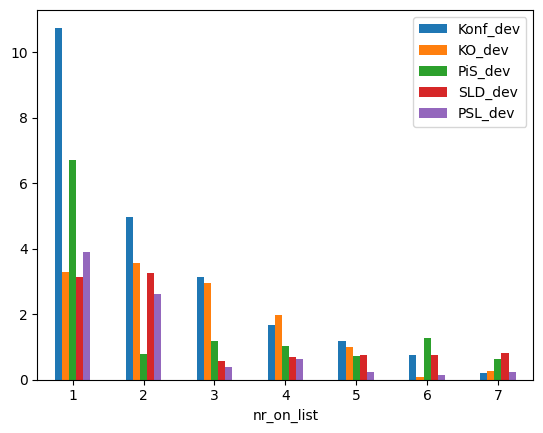

In [20]:
ax = df_mean.iloc[:7].plot(x="nr_on_list", y=['Konf_dev', 'KO_dev', 'PiS_dev', 'SLD_dev', 'PSL_dev'], kind='bar', rot=0)

Konf is quite obvious outliner there